In [1]:
#| code-summary: code -- load dependencies and data and select parameters
#| echo: false
#| output: false

from compmemlearn.fitting import generate_objective_function, model_weights
from compmemlearn.datasets import events_metadata, generate_trial_mask, simulate_df_from_events
from compmemlearn.datasets import retrieve_trial_features
from sentence_transformers import util
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import os

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

figure_caption = """Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model."""


section_tag = "catCDCATBEH"
data_path = "C:/Users/gunnj/compmemlearn/data/CDCATBEH.csv"
results_path = "../../reports/subjectwise_model_evaluation/results/"
figures_path = "figures/"
trial_query = "subject > -1"

language_model_string = 'cat'
embedding_path = f'../../data/cdcatmr-{language_model_string}.npy'

model_paths = [
    "compmemlearn.models.Bi_Semantic_CMR",
]

model_names = ["Semantic_CMR"]

free_parameters = [
        [
        "distraction_drift_rate",
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
        "semantic_scale"
    ],
]
bounds = [
        [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
    ],
]
fixed_parameters = [
    {}
]

switch_query = "list_type == 'light'"

analysis_paths = ['compmemlearn.analyses.plot_spc', 'compmemlearn.analyses.plot_crp', 'compmemlearn.analyses.plot_pfr', 'compmemlearn.analyses.plot_sem_crp']
analysis_names = ['spc', 'crp', 'pfr', 'semcrp']

experiment_count = 100

In [2]:
#| echo: false
#| output: false

always_free = []

if switch_query is not None:

    base_free_parameters = free_parameters[0]
    base_bounds = bounds[0]
    base_model_path = model_paths[0]
    base_model_name = model_names[0]
    base_fixed_parameters = fixed_parameters[0]

    free_parameters = []
    fixed_parameters = []
    bounds = []
    model_paths = []
    model_names = []

    # iteratively generate hierarchical models that vary a single free parameter at a time
    for i in range(len(base_free_parameters)):

        if base_free_parameters[i] in always_free:
            continue

        free_parameters.append([])
        fixed_parameters.append({})
        bounds.append([])
        model_paths.append(base_model_path)
        model_names.append(f"free_{len(always_free)}_{base_free_parameters[i]}_{base_model_name}")

        for j in range(len(base_free_parameters)):
            free_parameters[-1].append('0_' + base_free_parameters[j])
            bounds[-1].append(base_bounds[j])

            if (j == i) or (base_free_parameters[j] in always_free):
                free_parameters[-1].append('1_' + base_free_parameters[j])
                bounds[-1].append(base_bounds[j])
            else:
                fixed_parameters[-1]['1_' + base_free_parameters[j]] = 0.0

In [3]:
#| echo: false
#| output: false

if 'Howard' in section_tag or ('Lohnas' in section_tag and '1' not in section_tag):
    analysis_paths = ['compmemlearn.analyses.plot_flex_spc', 'compmemlearn.analyses.plot_flex_crp', 'compmemlearn.analyses.plot_flex_pfr', 'compmemlearn.analyses.plot_rpl']
    analysis_names = ['spc', 'crp', 'pfr', 'rpl']


print(os.path.abspath(data_path))

C:\Users\gunnj\compmemlearn\data\CDCATBEH.csv


In [4]:
#| code-summary: code -- test that specified parameters are valid
#| echo: false
#| output: false

events = pd.read_csv(data_path)

trials, list_lengths, presentations, string_ids = events_metadata(events)[:4]
trial_mask = generate_trial_mask(events, trial_query)

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1)
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# import analyses from specified source
analyses = []
for i in range(len(analysis_paths)):
    module_name, analysis_name = analysis_paths[i].rsplit('.',1)
    module = importlib.import_module(module_name)
    analyses.append(getattr(module, analysis_name))

# load language model and relevant item strings
if embedding_path is not None:
    string_embeddings =  np.load(embedding_path)
else:
    string_embeddings = None

# generate switch masks from key
if switch_query is not None:
    switch_mask = generate_trial_mask(events, switch_query)
else:
    switch_mask = None
    
# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    extra_mask = generate_trial_mask(events, f'subject == {pd.unique(events.subject)[0]}')
    subject_specific_trial_mask = [np.logical_and(extra_mask[i], trial_mask[i]) for i in range(len(trial_mask))]

    cost_function = generate_objective_function(
        [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
        [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
        list_lengths,
        init_model,
        fixed_parameters[model_index],
        free_parameters[model_index],
        string_embeddings,
        [string_ids[i][subject_specific_trial_mask[i]] for i in range(len(trials))] if (
            string_ids is not None) else string_ids,
        [switch_mask[i][subject_specific_trial_mask[i]] for i in range(len(switch_mask))] if (
            switch_mask is not None) else switch_mask,
    )
    print(cost_function)
    
    for boundary_index in range(2):
        x = np.array([each[boundary_index] for each in bounds[model_index]])
        assert(len(x) == len(free_parameters[model_index])) 

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        if switch_query is not None:
            parameters['switch'] = 0.0 if boundary_index == 0 else 1.0

        if string_embeddings is None:
            model = init_model(20, 20, parameters)
        else:
            trial_embeddings = string_embeddings[string_ids[0][0]]
            cosine_scores = util.pytorch_cos_sim(trial_embeddings, trial_embeddings).numpy() + 1
            np.fill_diagonal(cosine_scores, 0)
            model = init_model(cosine_scores, len(string_ids[0][0]), parameters)

        model.experience(model.items)
        model.free_recall()

        print(cost_function(x))

    # we won't do this validation across all models since we're reusing the same model across comparisons
    if switch_query is not None:
        break

print('dependencies and parameters validated')

<function bifurcated_semantic_objective_function.<locals>.objective_function at 0x000001ED54496E50>
600.0600765402628
1726.938910746251
dependencies and parameters validated


In [5]:
#| code-summary: code -- 1) fit each model class participant-by-participant
#| echo: false
#| output: false

for model_index, model_class in enumerate(models):

    # load individual fits for this model and section tag from csv if they exist
    if os.path.isfile(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])):
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]))
        print('individual fits for {} with tag {} already exist'.format(model_names[model_index], section_tag))

    # otherwise, fit each participant individually
    else:
        model_individual_fits = []

        @njit(fastmath=True, nogil=True)
        def init_model(item_count, presentation_count, parameters):
            return model_class(item_count, presentation_count, parameters)

        for subject in pd.unique(events.subject):
            print(f'{model_names[model_index]}, Subject {subject}')

            extra_mask = generate_trial_mask(events, f'subject == {subject}')
            subject_specific_trial_mask = [
                np.logical_and(extra_mask[i], trial_mask[i]) for i in range(len(trial_mask))]
            
            try:
                # cost function to be minimized
                # ours scales inversely with the probability that the data could have been
                # generated using the specified parameters and our model
                cost_function = generate_objective_function(
                    [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
                    [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
                    list_lengths,
                    init_model,
                    fixed_parameters[model_index],
                    free_parameters[model_index],
                    string_embeddings,
                    [string_ids[i][subject_specific_trial_mask[i]] for i in range(len(trials))] if (
                        string_ids is not None) else string_ids,
                    [switch_mask[i][subject_specific_trial_mask[i]] for i in range(len(switch_mask))] if (switch_mask is not None) else switch_mask
                )
            except ValueError:
                continue

            fit_result =  differential_evolution(cost_function, bounds[model_index], disp=False)

            fitted_parameters = {
                'subject': subject, 
                'trial_count': np.sum(
                    [np.sum(subject_specific_trial_mask[i]) for i in range(len(subject_specific_trial_mask))]), 
                'likelihood': fit_result.fun, 'model': model_names[model_index]
                }
            for i in range(len(fit_result.x)):
                fitted_parameters[free_parameters[model_index][i]] = fit_result.x[i]
            for key in fixed_parameters[model_index]:
                fitted_parameters[key] = fixed_parameters[model_index][key]

            model_individual_fits.append(
                pd.DataFrame.from_dict(fitted_parameters, orient='index').T)
            print(model_individual_fits[-1]['likelihood'][0])

        model_individual_fits = pd.concat(model_individual_fits, ignore_index=True)
        model_individual_fits.to_csv(
            results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]), index=False)

free_0_distraction_drift_rate_Semantic_CMR, Subject 1
310.4620813245457
free_0_distraction_drift_rate_Semantic_CMR, Subject 2
312.3966906610592
free_0_distraction_drift_rate_Semantic_CMR, Subject 3
336.0309231612772
free_0_distraction_drift_rate_Semantic_CMR, Subject 5
415.50819498464415
free_0_distraction_drift_rate_Semantic_CMR, Subject 6
230.45776665448426
free_0_distraction_drift_rate_Semantic_CMR, Subject 7
269.92957391702976
free_0_distraction_drift_rate_Semantic_CMR, Subject 8
108.44075528747007
free_0_distraction_drift_rate_Semantic_CMR, Subject 9
247.96619038856312
free_0_distraction_drift_rate_Semantic_CMR, Subject 10
230.4371866788544
free_0_distraction_drift_rate_Semantic_CMR, Subject 11
246.93929531298974
free_0_distraction_drift_rate_Semantic_CMR, Subject 12
100.20792433917255
free_0_distraction_drift_rate_Semantic_CMR, Subject 13
223.83321813736927
free_0_distraction_drift_rate_Semantic_CMR, Subject 14
301.61972015995354
free_0_distraction_drift_rate_Semantic_CMR, Subjec

c:\ProgramData\Miniconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 25.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\ProgramData\Miniconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 22.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\ProgramData\Miniconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 20.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\ProgramData\Miniconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 24.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\ProgramData\Miniconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 23.6% of the p

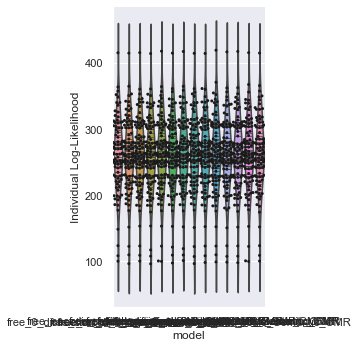

In [6]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects
#| echo: false

plt.style.use('default')
sns.set(style="darkgrid")

# build individual fits df concatenating results from each model
individual_fits = []
for model_index, model_class in enumerate(models):
    individual_fits.append(
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])))
individual_fits = pd.concat(individual_fits, ignore_index=True)

# plot distribution of log-likelihoods across individual subjects
g = sns.catplot(x='model', y='likelihood', data=individual_fits, kind='violin', inner='stick')
sns.swarmplot(x="model", y="likelihood", data=individual_fits, color="k", size=3, ax=g.ax)
g.ax.set_ylabel('Individual Log-Likelihood');
plt.savefig(figures_path + 'individual_{}.pdf'.format(section_tag), bbox_inches="tight")

In [7]:
#| echo: false
#| output: false

individual_fits

,subject,trial_count,likelihood,model,0_distraction_drift_rate,1_distraction_drift_rate,0_encoding_drift_rate,0_start_drift_rate,0_recall_drift_rate,0_shared_support,...,1_shared_support,1_item_support,1_learning_rate,1_primacy_scale,1_primacy_decay,1_stop_probability_scale,1_stop_probability_growth,1_choice_sensitivity,1_delay_drift_rate,1_semantic_scale
0,1,8,310.462081,free_0_distraction_drift_rate_Semantic_CMR,0.916986,0.094986,0.750486,0.605865,0.834496,0.462443,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,2,8,312.396691,free_0_distraction_drift_rate_Semantic_CMR,0.311088,0.774160,0.627494,0.142012,0.529345,0.488716,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,3,8,336.030923,free_0_distraction_drift_rate_Semantic_CMR,0.267048,0.819151,0.305496,0.172616,0.475507,0.491344,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,5,8,415.508195,free_0_distraction_drift_rate_Semantic_CMR,0.681068,0.438723,0.755638,0.123236,0.830112,0.345328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,6,8,230.457767,free_0_distraction_drift_rate_Semantic_CMR,0.543355,0.322888,0.677114,0.224408,0.993980,0.790629,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241,92,8,204.732469,free_semantic_scale_Semantic_CMR,NaN,NaN,0.832683,0.110728,0.444625,0.014381,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.228703
1242,94,8,257.726016,free_semantic_scale_Semantic_CMR,NaN,NaN,0.660846,0.768708,0.469025,0.025658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651838
1243,95,8,152.029584,free_semantic_scale_Semantic_CMR,NaN,NaN,0.540879,0.040113,0.980268,0.691818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.089866
1244,96,8,310.088053,free_semantic_scale_Semantic_CMR,NaN,NaN,0.641134,0.071213,0.700040,0.514186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.351998


In [8]:
#| code-summary: display markdown rendering of summary table
#| echo: false
#| output: asis

summary_table = pd.DataFrame(group.describe().rename(columns={'likelihood':name}).squeeze()
            for name, group in individual_fits[['model', 'likelihood']].groupby('model')).T.to_markdown()

print("""::: {{#fig-{section_tag}fits layout-nrow=2 layout-valign="center"}}

![]({figures_path}individual_{section_tag}.pdf)

{summary_table}

{individual_fits_caption}
:::""".format(section_tag=section_tag, summary_table=summary_table, individual_fits_caption=figure_caption, figures_path=figures_path))

summary_table

::: {#fig-catCDCATBEHfits layout-nrow=2 layout-valign="center"}

![](figures/individual_catCDCATBEH.pdf)

|       |   free_0_distraction_drift_rate_Semantic_CMR |   free_choice_sensitivity_Semantic_CMR |   free_delay_drift_rate_Semantic_CMR |   free_encoding_drift_rate_Semantic_CMR |   free_item_support_Semantic_CMR |   free_learning_rate_Semantic_CMR |   free_primacy_decay_Semantic_CMR |   free_primacy_scale_Semantic_CMR |   free_recall_drift_rate_Semantic_CMR |   free_semantic_scale_Semantic_CMR |   free_shared_support_Semantic_CMR |   free_start_drift_rate_Semantic_CMR |   free_stop_probability_growth_Semantic_CMR |   free_stop_probability_scale_Semantic_CMR |
|:------|---------------------------------------------:|---------------------------------------:|-------------------------------------:|----------------------------------------:|---------------------------------:|----------------------------------:|----------------------------------:|----------------------------------:|-------

'|       |   free_0_distraction_drift_rate_Semantic_CMR |   free_choice_sensitivity_Semantic_CMR |   free_delay_drift_rate_Semantic_CMR |   free_encoding_drift_rate_Semantic_CMR |   free_item_support_Semantic_CMR |   free_learning_rate_Semantic_CMR |   free_primacy_decay_Semantic_CMR |   free_primacy_scale_Semantic_CMR |   free_recall_drift_rate_Semantic_CMR |   free_semantic_scale_Semantic_CMR |   free_shared_support_Semantic_CMR |   free_start_drift_rate_Semantic_CMR |   free_stop_probability_growth_Semantic_CMR |   free_stop_probability_scale_Semantic_CMR |\n|:------|---------------------------------------------:|---------------------------------------:|-------------------------------------:|----------------------------------------:|---------------------------------:|----------------------------------:|----------------------------------:|----------------------------------:|--------------------------------------:|-----------------------------------:|----------------------------------

In [9]:
#| code-summary: perform t-tests on individual-level fits
#| output: asis
#| echo: false
 
from scipy.stats import ttest_rel
import itertools

for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='two-sided'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='less'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='greater'))
    print()

('free_0_distraction_drift_rate_Semantic_CMR', 'free_encoding_drift_rate_Semantic_CMR')
Ttest_relResult(statistic=-0.47297526898066283, pvalue=0.6374018925003135)
Ttest_relResult(statistic=-0.47297526898066283, pvalue=0.31870094625015677)
Ttest_relResult(statistic=-0.47297526898066283, pvalue=0.6812990537498433)

('free_0_distraction_drift_rate_Semantic_CMR', 'free_start_drift_rate_Semantic_CMR')
Ttest_relResult(statistic=0.10157355554185513, pvalue=0.9193262519300414)
Ttest_relResult(statistic=0.10157355554185513, pvalue=0.5403368740349793)
Ttest_relResult(statistic=0.10157355554185513, pvalue=0.4596631259650207)

('free_0_distraction_drift_rate_Semantic_CMR', 'free_recall_drift_rate_Semantic_CMR')
Ttest_relResult(statistic=1.8086314060283826, pvalue=0.07392368154184752)
Ttest_relResult(statistic=1.8086314060283826, pvalue=0.9630381592290762)
Ttest_relResult(statistic=1.8086314060283826, pvalue=0.03696184077092376)

('free_0_distraction_drift_rate_Semantic_CMR', 'free_shared_support_S

In [10]:
#| echo: false
#| output: asis

for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(np.mean(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.mean(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print(np.sum(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.sum(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print()

('free_0_distraction_drift_rate_Semantic_CMR', 'free_encoding_drift_rate_Semantic_CMR')
0.5617977528089888 0.43820224719101125
50 39

('free_0_distraction_drift_rate_Semantic_CMR', 'free_start_drift_rate_Semantic_CMR')
0.5393258426966292 0.4606741573033708
48 41

('free_0_distraction_drift_rate_Semantic_CMR', 'free_recall_drift_rate_Semantic_CMR')
0.3595505617977528 0.6404494382022472
32 57

('free_0_distraction_drift_rate_Semantic_CMR', 'free_shared_support_Semantic_CMR')
0.6067415730337079 0.39325842696629215
54 35

('free_0_distraction_drift_rate_Semantic_CMR', 'free_item_support_Semantic_CMR')
0.5056179775280899 0.4943820224719101
45 44

('free_0_distraction_drift_rate_Semantic_CMR', 'free_learning_rate_Semantic_CMR')
0.6179775280898876 0.38202247191011235
55 34

('free_0_distraction_drift_rate_Semantic_CMR', 'free_primacy_scale_Semantic_CMR')
0.6629213483146067 0.33707865168539325
59 30

('free_0_distraction_drift_rate_Semantic_CMR', 'free_primacy_decay_Semantic_CMR')
0.5842696629

In [11]:
#| echo: false
#| output: asis

aicw = {'Model': [], 'Subject': [], 'AICw': []}

total_nlns = np.zeros(len(models))
for subject_index, subject in enumerate(pd.unique(events.subject)):

    extra_mask = generate_trial_mask(events, f'subject == {subject}')
    subject_specific_trial_mask = [
        np.logical_and(extra_mask[i], trial_mask[i]) for i in range(len(trial_mask))]

    nlnLs = []
    for model_index, model_class in enumerate(models):
        nlnLs.append(
            individual_fits[individual_fits.model == model_names[model_index]].likelihood.values[subject_index])
    nlnLs = np.array(nlnLs)
    total_nlns += nlnLs
    
    weights = model_weights(nlnLs, len(free_parameters[model_index]), np.sum(
                    [np.sum(subject_specific_trial_mask[i]) for i in range(len(subject_specific_trial_mask))]))
    #print(weights)
    for model_index, model_class in enumerate(models):
        aicw['Model'].append(model_names[model_index])
        aicw['Subject'].append(subject)
        aicw['AICw'].append(weights[model_index])

aicw = pd.DataFrame(data=aicw)
total_aicw = model_weights(total_nlns, len(free_parameters[model_index]),np.sum(
                    [np.sum(trial_mask[i]) for i in range(len(trial_mask))]))
print(total_aicw)
model_names

IndexError: index 0 is out of bounds for axis 0 with size 0

In [12]:
#| echo: false

import seaborn as sns
sns.set_theme(style="darkgrid")
x = sns.pointplot(x="Model", y="AICw", data=aicw, join=False)

plt.show()
model_names

c:\ProgramData\Miniconda3\lib\site-packages\seaborn\categorical.py:250: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  vals = pd.Series(vals, index=index)


ValueError: min() arg is an empty sequence

In [ ]:
#| echo: false
#| output: false
from compmemlearn.datasets import find_first

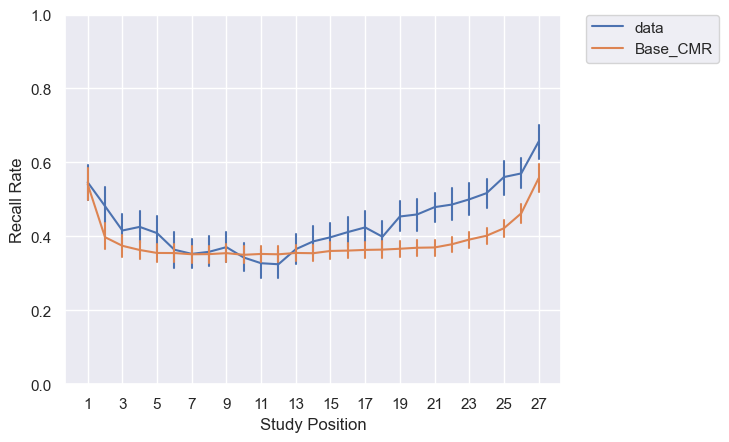

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


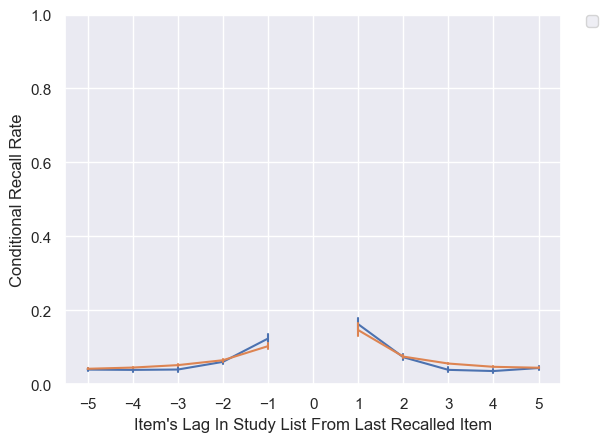

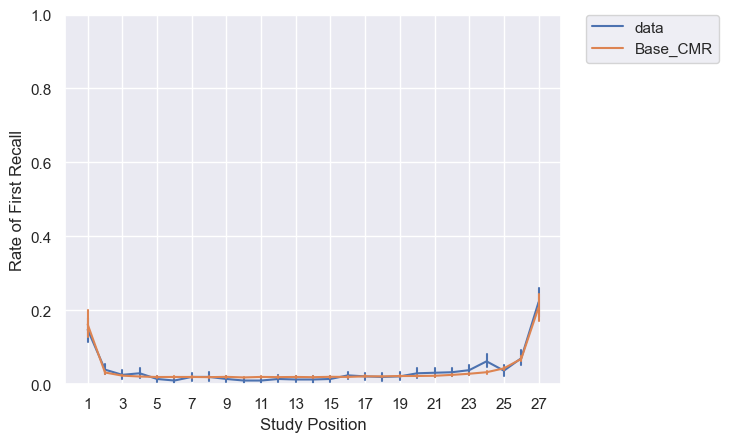

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


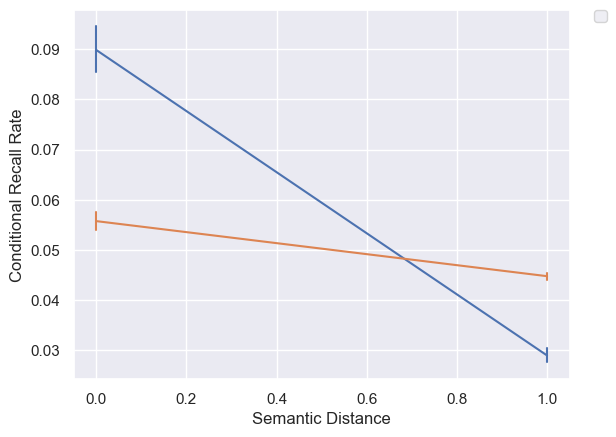

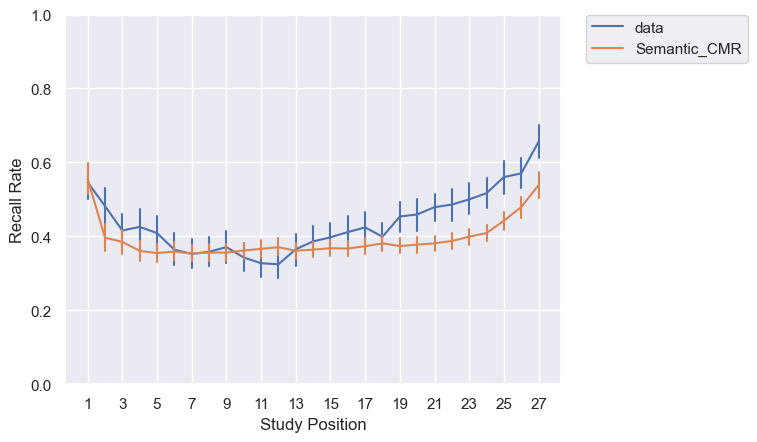

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


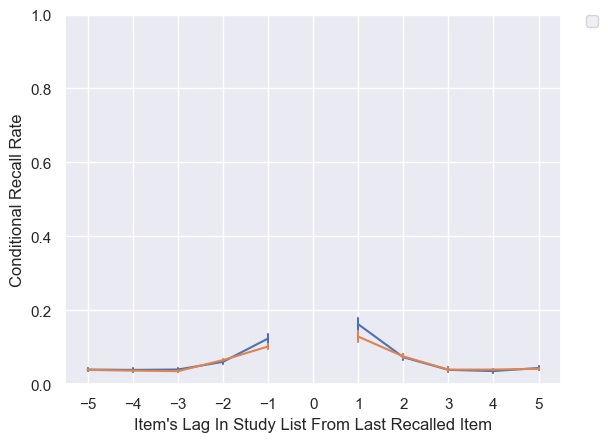

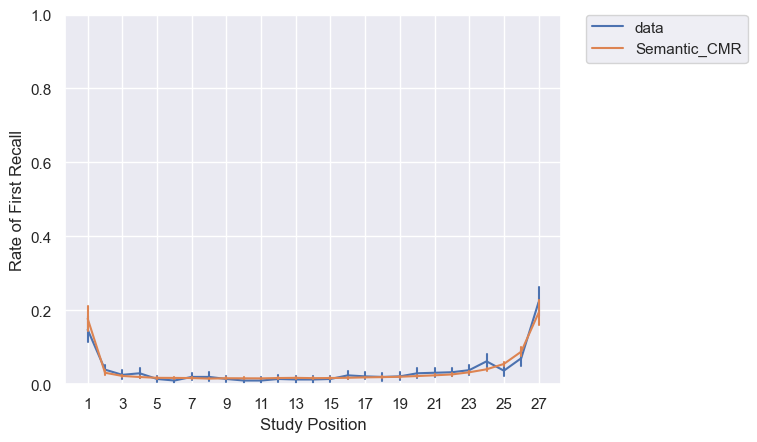

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


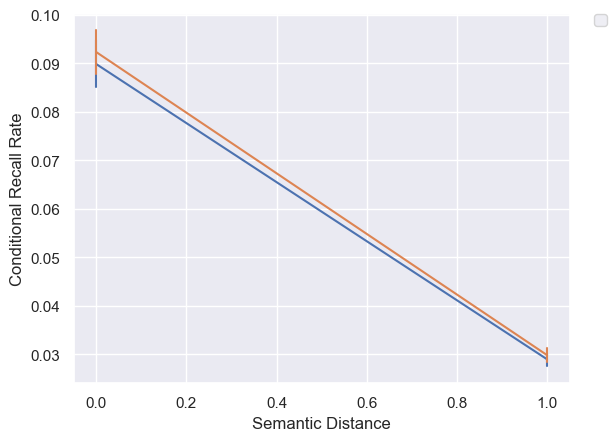

In [ ]:
#| echo: false
sns.set(style='darkgrid')

# for each unique list length
if not (isinstance(list_lengths, list) or isinstance(list_lengths, List)): 
    list_lengths = [list_lengths]

for ll_index, list_length in enumerate(list_lengths):
    
    # for each unique model
    for model_index, model_class in enumerate(models):

        # load sim_df from csv if it exists
        sim_df_path = results_path + '{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length)
        if os.path.isfile(sim_df_path):
            sim_df = pd.read_csv(sim_df_path)
            print('sim_df for {} with tag {} and list length {} already exists'.format(model_names[model_index], section_tag, list_length))

        # otherwise, generate it
        else:

            @njit(fastmath=True, nogil=True)
            def init_model(item_count, presentation_count, parameters):
                return model_class(item_count, presentation_count, parameters)

            # for each unique matching entry in individual df
            sim_dfs = []
            for subject in pd.unique(individual_fits.subject):
                
                fit_result = individual_fits.query(f'subject == {subject} & model == "{model_names[model_index]}"')

                # configure model based on specified parameters
                fitted_parameters = Dict.empty(
                    key_type=types.unicode_type, value_type=types.float64
                )
                for i in range(len(free_parameters[model_index])):
                    fitted_parameters[free_parameters[model_index][i]] = fit_result[free_parameters[model_index][i]].values[0]
                for key in fixed_parameters[model_index]:
                    fitted_parameters[key] = fixed_parameters[model_index][key]

                if 'list length' in events.columns:
                    ll_specific_trial_query = trial_query + f' & subject == {subject} & `list length` == {list_length}'
                else:
                    ll_specific_trial_query = trial_query + f' & subject == {subject}'

                trial_mask = generate_trial_mask(events, ll_specific_trial_query)
                if np.sum([np.sum(trial_mask[i]) for i in range(len(trial_mask))]) == 0:
                    continue

                # simulate df based on specified trial_count and experiment_count
                sim_dfs.append(simulate_df_from_events(
                    init_model, fitted_parameters, events, ll_specific_trial_query, experiment_count, 
                    string_embeddings=string_embeddings))
                sim_dfs[-1].subject = subject
                sim_dfs[-1].list_length = list_length

            # concatenate simulations into one dataframe
            if len(sim_dfs) == 0:
                sim_df = None
                continue
            sim_df = pd.concat(sim_dfs)

            # save sim_df to csv
            sim_df.to_csv(sim_df_path.format(
                section_tag, model_names[model_index], list_length), index=False)

        if sim_df is None:
            continue

        # design general filter for analysis df
        if len(list_lengths) > 1:
            analysis_query = trial_query + f' & `list length` == {list_length}'
        else:
            analysis_query = trial_query
            
        # generate plot for each parametrized analysis and model
        for analysis_index, analysis_function in enumerate(analyses):
            analysis_name = analysis_names[analysis_index]

            if analysis_name != 'semcrp':
                axis, result = analysis_function(
                    [events, sim_df], analysis_query, contrast_name="source", 
                    labels=["data", model_names[model_index]])
            else:
                axis, result = analysis_function(
                    [events, sim_df], analysis_query, string_embeddings, contrast_name="source", 
                    labels=["data", model_names[model_index]])
            result.to_csv(results_path + '{}_{}_ll{}_{}.csv'.format(section_tag, model_names[model_index], list_length, analysis_name), index=False)
            plt.savefig(figures_path+'{}_{}_ll{}_{}.pdf'.format(section_tag, model_names[model_index], list_length, analysis_name), bbox_inches="tight")
            plt.show()